In [1]:
import random
import time
import datetime
import sys

from torch.autograd import Variable
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import glob
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time

from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets

### Do domain adaptation

In [2]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [3]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


class ImageDataset(Dataset):
    def __init__(self, files_path_A, files_path_B, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(files_path_A)
        self.files_B = sorted(files_path_B)

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [4]:
files_path_A = [f'/kaggle/input/kitti-dataset/data_object_image_3/training/image_3/{i}'
                    for i in os.listdir('/kaggle/input/kitti-dataset/data_object_image_3/training/image_3')]
files_path_A.extend([f'/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/{i}'
                   for i in os.listdir('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3')])

files_path_B = [f'/kaggle/input/synthiarandcityscape/RGB/RGB/{i}'
                   for i in os.listdir('/kaggle/input/synthiarandcityscape/RGB/RGB')]

np.random.shuffle(files_path_A)
np.random.shuffle(files_path_B)
n = len(files_path_A)
m = len(files_path_B)

train_size = 0.8

train_path_A = files_path_A[:int(n * train_size)]
val_path_A = files_path_A[int(n * train_size):]

train_path_B = files_path_B[:int(m * train_size)]
val_path_B = files_path_B[int(m * train_size):]

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           RESNET           #
##############################


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [6]:
class Config:
    pass

opt = Config()

opt.epoch = 0
opt.n_epochs = 2
opt.batch_size = 4
opt.lr = 0.0002
opt.b1 = 0.5
opt.b2 = 0.999
opt.decay_epoch = 1
opt.n_cpu = 8
opt.img_height = 256
opt.img_width = 256
opt.channels = 3
opt.sample_interval = 200
opt.checkpoint_interval = 500
opt.n_residual_blocks = 9
opt.lambda_cyc = 10.
opt.lambda_id = 5.

In [7]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

cuda = torch.cuda.is_available()

input_shape = (opt.channels, opt.img_height, opt.img_width)

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, opt.n_residual_blocks)
G_BA = GeneratorResNet(input_shape, opt.n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()


# Initialize weights
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step
)

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Image transformations
transforms_ = [
    transforms.Resize(int(opt.img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((opt.img_height, opt.img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Training data loader
dataloader = DataLoader(
    ImageDataset(train_path_A, train_path_B, transforms_=transforms_),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
)
# Test data loader
val_dataloader = DataLoader(
    ImageDataset(val_path_A, val_path_B, transforms_=transforms_, mode="test"),
    batch_size=5,
    shuffle=True,
    num_workers=1,
)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "./%s/%s.png" % ("styleTransfer", batches_done), normalize=False)

In [9]:
from tqdm.notebook import tqdm

In [12]:
os.mkdir('styleTransfer')
os.mkdir('saved_models')

In [13]:
# ----------
#  Training
# ----------

prev_time = time.time()
for epoch in range(opt.n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        torch.cuda.empty_cache()
        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + opt.lambda_cyc * loss_cycle + opt.lambda_id * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------

        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------

        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = opt.n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
            % (
                epoch,
                opt.n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                loss_identity.item(),
                time_left,
            )
        )

        # If at sample interval save image
        if batches_done % opt.sample_interval == 0:
            sample_images(batches_done)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    if (i+1) % opt.checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(G_AB.state_dict(), "saved_models/G_AB_%d.pth" % (i+1))
        torch.save(G_BA.state_dict(), "saved_models/G_BA_%d.pth" % (i+1))
        torch.save(D_A.state_dict(), "saved_models/D_A_%d.pth" % (i+1))
        torch.save(D_B.state_dict(), "saved_models/D_B_%d.pth" % (i+1))

  0%|          | 0/3000 [00:00<?, ?it/s]

[Epoch 0/2] [Batch 2999/3000] [D loss: 0.201766] [G loss: 1.909854, adv: 0.440835, cycle: 0.098467, identity: 0.096871] ETA: 1:07:19.013879

  0%|          | 0/3000 [00:00<?, ?it/s]

[Epoch 1/2] [Batch 2999/3000] [D loss: 0.218501] [G loss: 1.605432, adv: 0.292684, cycle: 0.090386, identity: 0.081778] ETA: 0:00:01.361748

In [16]:
os.chdir('/kaggle/working')
!zip -r weights.zip '/kaggle/working/saved_models'

updating: kaggle/working/saved_models/ (stored 0%)
updating: kaggle/working/saved_models/G_BA_3000.pth (deflated 7%)
updating: kaggle/working/saved_models/G_AB_3000.pth (deflated 7%)
updating: kaggle/working/saved_models/D_B_3000.pth (deflated 7%)
updating: kaggle/working/saved_models/D_A_3000.pth (deflated 7%)


In [17]:
os.chdir('/kaggle/working')
!zip -r results.zip '/kaggle/working/styleTransfer'

updating: kaggle/working/styleTransfer/ (stored 0%)
updating: kaggle/working/styleTransfer/0.png (deflated 0%)
updating: kaggle/working/styleTransfer/3600.png (deflated 0%)
updating: kaggle/working/styleTransfer/3800.png (deflated 0%)
updating: kaggle/working/styleTransfer/4400.png (deflated 0%)
updating: kaggle/working/styleTransfer/5600.png (deflated 0%)
updating: kaggle/working/styleTransfer/3200.png (deflated 0%)
updating: kaggle/working/styleTransfer/5200.png (deflated 0%)
updating: kaggle/working/styleTransfer/5400.png (deflated 0%)
updating: kaggle/working/styleTransfer/1000.png (deflated 0%)
updating: kaggle/working/styleTransfer/2200.png (deflated 0%)
updating: kaggle/working/styleTransfer/200.png (deflated 0%)
updating: kaggle/working/styleTransfer/1800.png (deflated 0%)
updating: kaggle/working/styleTransfer/2400.png (deflated 0%)
updating: kaggle/working/styleTransfer/1200.png (deflated 0%)
updating: kaggle/working/styleTransfer/5800.png (deflated 0%)
updating: kaggle/worki

In [10]:
G_AB.load_state_dict(torch.load('/kaggle/input/course-project-weights/G_AB_3000.pth'))
D_B.load_state_dict(torch.load('/kaggle/input/course-project-weights/D_B_3000.pth'))

<All keys matched successfully>

In [11]:
device = 'cuda'

In [20]:
errs = []
D_B.eval()
G_AB.eval()

with torch.no_grad():
    for i, batch in enumerate(tqdm(val_dataloader)):
        A = batch['A'].to(device)
        B = batch['B'].to(device)
        valid = Variable(Tensor(np.ones((A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((A.size(0), *D_A.output_shape))), requires_grad=False)
        
        loss_real = criterion_GAN(D_B(B), valid)
        loss_fake = criterion_GAN(D_B(G_AB(A)), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        errs.append(loss_D_B.item())
        
#         if i == 100:
#             break
np.mean(errs)

  0%|          | 0/600 [00:00<?, ?it/s]

0.18690441026041904

### Inference

In [12]:
G_BC = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False)

G_BC.to(device)
G_BC.load_state_dict(torch.load('/kaggle/input/course-project-weights/img2depth_g.pth'))


/opt/conda/lib/python3.10/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip


<All keys matched successfully>

In [13]:
val_dataset = ImageDataset(val_path_A, val_path_B, transforms_=transforms_, mode="test")

In [14]:
def image_to_torch(image, device=None):
    """Convert Numpy image to Torch tensor."""
    if isinstance(image, torch.Tensor):
        return image
    if image.shape[-1] == 4:
        image = image[..., :3]
    result = torch.from_numpy(np.ascontiguousarray(image))
    if device is not None:
        result = result.to(device)
    #if len(result.shape) == 3:
    result = result.permute(2, 0, 1)
    return result

  
def image_to_numpy(image):
    """Convert Torch tensor to Numpy image."""
    if isinstance(image, np.ndarray):
        return image
    if image.dtype == torch.float32:
        image = image - image.min()
        image = 255 * image / max(1e-6, image.max())
    #if len(image.shape) == 3:
    return image.to(torch.uint8).permute(1, 2, 0).cpu().numpy()
    #return image.to(torch.uint8).cpu().numpy()

In [15]:
import matplotlib.pyplot as plt

In [39]:
def inference_naive(n=5):
    with torch.no_grad():
        for _ in range(n):
            item = val_dataset[np.random.choice(len(val_dataset))]
            a = item['A']
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.imshow(image_to_numpy(a))
            ax1.axis('off')
            ax2.imshow(image_to_numpy(G_BC(a.unsqueeze(0).to(device)).squeeze(0)))
            ax2.axis('off')

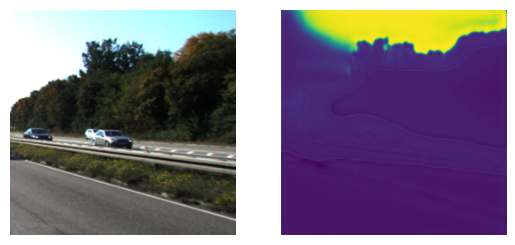

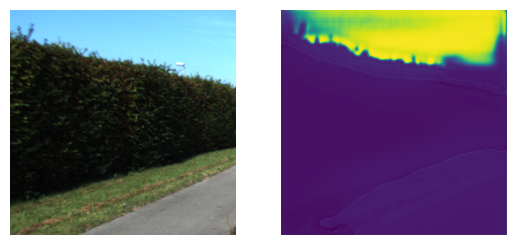

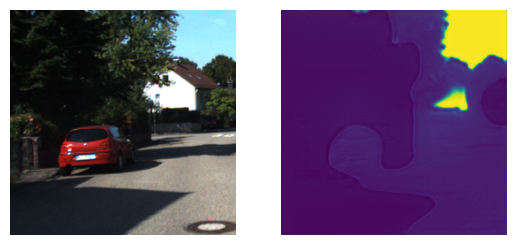

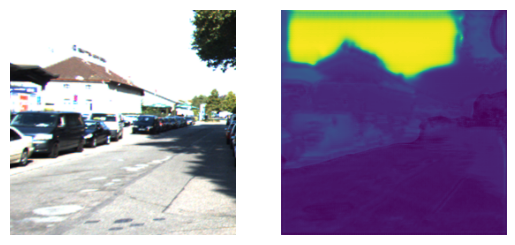

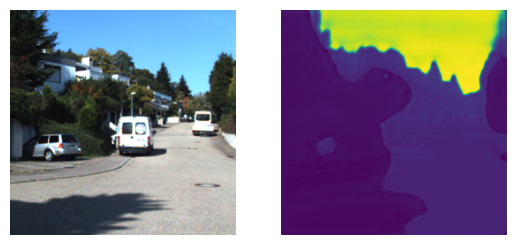

In [40]:
inference_naive()

In [16]:
def inference(n=5):
    with torch.no_grad():
        for _ in range(n):
            item = val_dataset[np.random.choice(len(val_dataset))]
            a = item['A']
            b = G_AB(a.unsqueeze(0).to(device))
            c = G_BC(b)
            fig, (ax1,jij, ax2, ax3) = plt.subplots(1, 4)
            ax1.imshow(image_to_numpy(a))
            ax1.axis('off')
            jij.imshow(image_to_numpy(G_BC(a.unsqueeze(0).to(device)).squeeze(0)))
            jij.axis('off')
            ax2.imshow(image_to_numpy(b.squeeze(0)))
            ax2.axis('off')
            ax3.imshow(image_to_numpy(c.squeeze(0)))
            ax3.axis('off')

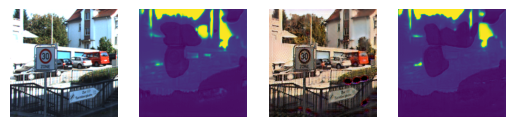

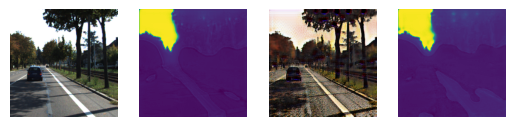

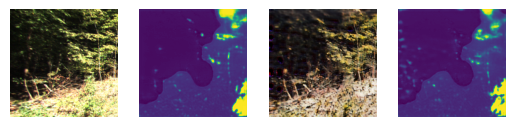

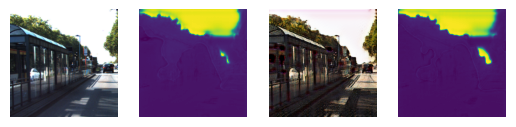

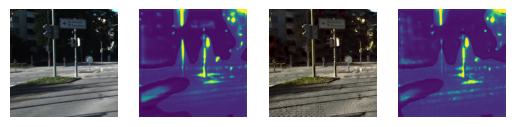

In [19]:
inference()